### Step 1: Data Acquisition

In [32]:
# Importing the Libarary
import yfinance as yf
import pandas as pd
import numpy as np

In [33]:
import yfinance as yf

# Download historical data for a specific stock (e.g., Apple Inc.)
data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)

# Display the first few rows of the dataframe
print(data.tail())


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-22  195.179993  195.410004  192.970001  193.600006  192.868134   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.320221   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.419830   
2023-12-28  194.139999  194.660004  193.169998  193.580002  192.848221   
2023-12-29  193.899994  194.399994  191.729996  192.529999  191.802170   

              Volume  
Date                  
2023-12-22  37122800  
2023-12-26  28919300  
2023-12-27  48087700  
2023-12-28  34049900  
2023-12-29  42628800  


### Step 2: Data Exploration and Preprocessing


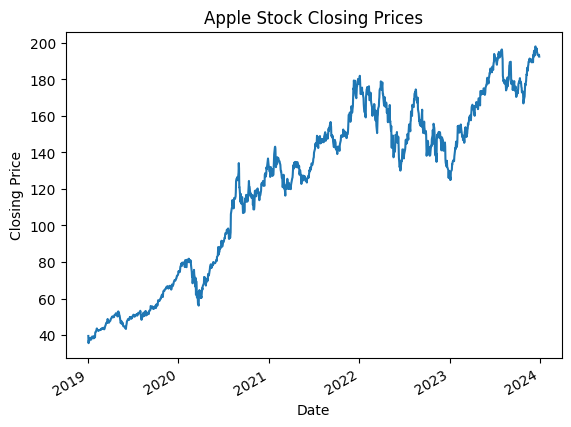

In [34]:
import matplotlib.pyplot as plt

# Plot the closing prices
data['Close'].plot(title='Apple Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Checking for missing values
# print(data.isnull().sum())

# Filling any missing values, if necessary
data.ffill(inplace=True)  # forward fill to propagate last valid observation


### Step 3: Feature Engineering

In [35]:
# Set 'Date' as index before dropping NaN values
# data.set_index('Date', inplace=True)
# Calculate moving averages
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Calculate daily returns
data['Returns'] = data['Close'].pct_change()

# Drop rows with NaN values that might have been created during feature engineering
data.dropna(inplace=True)

### Step 4: Building the Prediction Model

In [36]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'MA10', 'MA50', 'Returns']].values)



# Prepare input X and output Y for the LSTM model
X = []
Y = []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    Y.append(scaled_data[i, 0])

X, Y = np.array(X), np.array(Y)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


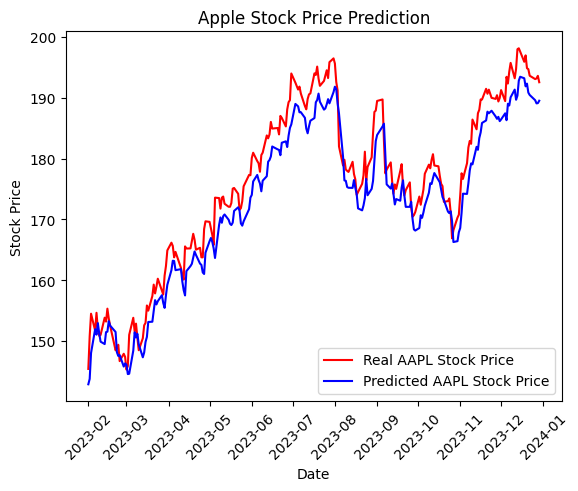

In [37]:
# Predicting and visualizing results
predicted_stock_price = model.predict(X_test)

# Reshape predicted_stock_price before inverse scaling
predicted_stock_price = predicted_stock_price.reshape(-1, 1)

# Inverse scaling for the 'Close' price only
predicted_stock_price = scaler.inverse_transform(np.hstack([predicted_stock_price, np.zeros((predicted_stock_price.shape[0], 3))]))[:, 0]

# Plotting real vs predicted values
plt.plot(data.index[train_size+60:], scaler.inverse_transform(np.hstack([Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 3))]))[:, 0], color='red', label='Real AAPL Stock Price')
plt.plot(data.index[train_size+60:], predicted_stock_price, color='blue', label='Predicted AAPL Stock Price')
plt.xticks(rotation=45)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()